### Import des données

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from io import StringIO
import sys

c:\Users\zergu\.conda\envs\venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Utilisation des générateurs pour importer plus efficacement 

In [6]:
%%time
import csv

def csv_to_dataframe(file_path):
    with open(file_path, 'r') as csvfile:
        csvreader = csv.reader(csvfile,delimiter=';')
        header = next(csvreader)  # Lire la première ligne comme en-têtes de colonnes
        yield header
        for row in csvreader:
            yield row
    return header

# Créer un générateur
csv_file_path = 'data/Breast_cancer_subtypes_samples.csv'
csv_gen = csv_to_dataframe(csv_file_path)

# Récupérer les en-têtes de colonnes
header = next(csv_gen)

# Utiliser pd.DataFrame pour créer un DataFrame à partir du générateur
df = pd.DataFrame(csv_gen,columns=header)

# Afficher le DataFrame
df

CPU times: total: 15.6 ms
Wall time: 121 ms


,Sample,Dataset,Non-tumour,All-tumours,Luminal-A,Luminal-B,HER2-enriched,Basal-like,Stage-I,Stage-II,Stage-III,Stage-IV,N0,N1,N2,N3,M1
0,TCGA-A7-A0CE-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,TCGA-A7-A0CH-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,TCGA-A7-A0D9-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TCGA-A7-A0DB-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TCGA-A7-A0DC-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,Miller-2005-X90A63,Miller-2005,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3696,Miller-2005-X94A16,Miller-2005,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3697,Miller-2005-X96A21,Miller-2005,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3698,Miller-2005-X99A50,Miller-2005,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [2]:
%%time
cancer = pd.read_csv('data/Breast_cancer_subtypes_samples.csv',sep=';')
cancer.head()

CPU times: total: 15.6 ms
Wall time: 16.6 ms


,Sample,Dataset,Non-tumour,All-tumours,Luminal-A,Luminal-B,HER2-enriched,Basal-like,Stage-I,Stage-II,Stage-III,Stage-IV,N0,N1,N2,N3,M1
0,TCGA-A7-A0CE-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,TCGA-A7-A0CH-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,TCGA-A7-A0D9-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TCGA-A7-A0DB-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TCGA-A7-A0DC-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Expressions data 

In [3]:
%%time
GSE21653 = pd.read_csv('data/expression_data_GSE21653_GSE21653_log_expression_266_samples_21887_genes.csv',sep=';')
Miller = pd.read_csv('data/expression_data_Miller-2005_Miller-2005_log_expression_251_samples_14145_genes.csv',sep=';')
Naderi_Caldas = pd.read_csv('data/expression_data_Naderi-Caldas-2007_Naderi-Caldas-2007_log_expression_242_samples_14366_genes.csv',sep=';')
E_MTAB_365 = pd.read_csv('data/expression_data_probreast_microarrays_E-MTAB-365_log_expression_1190_samples_23035_genes.csv',sep=';')
GSE25066 = pd.read_csv('data/expression_data_probreast_microarrays_GSE25066_log_expression_508_samples_13815_genes.csv',sep=';')
GSE42568 = pd.read_csv('data/expression_data_probreast_microarrays_GSE42568_log_expression_121_samples_23035_genes.csv',sep=';')
TCGA_BRCA = pd.read_csv('data/expression_data_tcga_brca_TCGA-BRCA_log_fpkm_1250_samples_42851_genes.csv',sep=';')
Yau = pd.read_csv('data/expression_data_Yau-2010_Yau-2010_log_expression_683_samples_8791_genes.csv',sep=';')

CPU times: total: 10.7 s
Wall time: 11.7 s


In [9]:
GSE21653.head()

,id_gene,gene_symbol,GSM540108,GSM540109,GSM540110,GSM540111,GSM540112,GSM540113,GSM540114,GSM540115,...,GSM540364,GSM540365,GSM540366,GSM540367,GSM540368,GSM540369,GSM540370,GSM540371,GSM540372,GSM540373
0,1,A1BG,6.146570,5.632868,7.407916,5.717083,5.667256,5.821602,5.582540,5.678218,...,5.768699,5.915461,5.332402,5.880671,5.785042,6.160731,5.855461,5.794792,5.933755,5.574898
1,2,A2M,8.935522,7.592040,11.160990,11.300994,10.900964,12.323455,11.599479,12.367085,...,11.718337,12.745096,11.950563,11.222791,13.871968,12.043786,10.892187,11.837682,11.622686,11.728424
2,3,A2MP1,4.456638,3.932945,4.321941,3.530977,4.226887,3.602626,3.622146,4.066038,...,4.154848,3.796254,3.629120,4.670076,4.505278,4.977037,4.197236,4.208478,3.696191,3.816247
3,9,NAT1,8.956687,7.689620,10.613485,6.990969,12.201209,5.273225,6.892088,6.652808,...,6.869943,5.774810,4.450702,3.805771,5.285668,5.511405,8.274637,5.201570,5.326663,6.283285
4,10,NAT2,4.519301,4.387033,4.087548,3.946865,10.145213,3.514774,3.627559,5.270486,...,4.083905,3.933584,3.869395,3.928023,3.928600,3.639174,6.260288,4.227776,4.161882,3.526315


In [10]:
%%time
def get_df(path):
    csv_gen = csv_to_dataframe(path)
    header = next(csv_gen)
    return pd.DataFrame(csv_gen,columns=header)

GSE21653 = get_df('data/expression_data_GSE21653_GSE21653_log_expression_266_samples_21887_genes.csv')
Miller = get_df('data/expression_data_Miller-2005_Miller-2005_log_expression_251_samples_14145_genes.csv')
Naderi_Caldas = get_df('data/expression_data_Naderi-Caldas-2007_Naderi-Caldas-2007_log_expression_242_samples_14366_genes.csv')
E_MTAB_365 = get_df('data/expression_data_probreast_microarrays_E-MTAB-365_log_expression_1190_samples_23035_genes.csv')
GSE25066 = get_df('data/expression_data_probreast_microarrays_GSE25066_log_expression_508_samples_13815_genes.csv')
GSE42568 = get_df('data/expression_data_probreast_microarrays_GSE42568_log_expression_121_samples_23035_genes.csv')
TCGA_BRCA = get_df('data/expression_data_tcga_brca_TCGA-BRCA_log_fpkm_1250_samples_42851_genes.csv')
Yau = get_df('data/expression_data_Yau-2010_Yau-2010_log_expression_683_samples_8791_genes.csv')

CPU times: total: 24.4 s
Wall time: 2min 1s


In [11]:
Yau.head()

,id_gene,gene_symbol,Yau-2010-103,Yau-2010-107,Yau-2010-109,Yau-2010-11,Yau-2010-110,Yau-2010-111,Yau-2010-113,Yau-2010-118,...,Yau-2010-GSM37053,Yau-2010-GSM37054,Yau-2010-GSM37055,Yau-2010-GSM37056,Yau-2010-GSM37057,Yau-2010-GSM37058,Yau-2010-GSM37059,Yau-2010-GSM37060,Yau-2010-GSM37061,Yau-2010-GSM37062
0,2,A2M,-1.599,0.719,-0.661,-0.272,-1.766,-3.305,-0.747,-0.815,...,1.154,-0.215,-0.742,0.895,-0.576,0.546,0.333,-0.182,-0.346,-0.038
1,9,NAT1,-3.14,3.38,-3.673,0.479,-2.374,3.631,-3.99,7.063,...,-3.634,-0.495,-0.435,0.869,3.355,0.104,3.545,-0.626,4.282,3.066
2,10,NAT2,0.398,0.296,1.185,0.129,-0.006,1.3,1.705,1.609,...,-1.425,0.449,1.022,0.049,-1.559,-1.568,7.644,-1.636,2.553,-1.131
3,12,SERPINA3,-3.399,-0.449,-1.616,-4.052,1.193,-0.751,0.95,1.562,...,1.532,-2.896,-6.36,0.908,1.929,0.158,-0.096,0.677,3.198,0.127
4,13,AADAC,-0.203,0.505,-0.241,0.347,0.355,-0.958,-0.143,0.576,...,-0.442,3.091,2.08,2.572,-1.553,2.614,-0.736,0.031,-0.399,1.688


#### Experimental Data

WITHOUT GENERATOR

In [4]:
%%time
GSE21653_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_GSE21653.xlsx')
GSE25066_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_GSE25066.xlsx')
GSE42568_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_GSE42568.xlsx')
TCGA_BRCA_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_TCGA-BRCA.xlsx')
Naderi_Caldas_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.12.01_Naderi-Caldas-2007.xlsx')
Yau_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.12.01_Yau-2010.xlsx')
Miller_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.12.02_Miller-2005.xlsx')
E_MTAB_365_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_E-MTAB-365.xlsx')

c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:

CPU times: total: 2.75 s
Wall time: 3.96 s


In [13]:
Naderi_Caldas_EG

,id_sample,main_gse_number,id_platform,sample_title,sample_source,sex,ethnic_group,age_min,age_max,id_tissue_stage,...,os_months,relapsed,dead,treatment,exposure,tissue_group_level1,tissue_group_level2,tissue_group_level3,os_censor,dfs_censor
0,Naderi-Caldas-2007-2073,Naderi-Caldas-2007,NaN,2073,Xena,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,breast,female_genital,soma,NaN,NaN
1,Naderi-Caldas-2007-2075,Naderi-Caldas-2007,NaN,2075,Xena,NaN,NaN,46.0,46.0,1,...,69.00000,True,True,NaN,NaN,breast,female_genital,soma,1.0,1.0
2,Naderi-Caldas-2007-2077,Naderi-Caldas-2007,NaN,2077,Xena,NaN,NaN,59.0,59.0,1,...,161.00040,False,False,NaN,NaN,breast,female_genital,soma,0.0,0.0
3,Naderi-Caldas-2007-2078,Naderi-Caldas-2007,NaN,2078,Xena,NaN,NaN,59.0,59.0,1,...,159.99960,False,False,NaN,NaN,breast,female_genital,soma,0.0,0.0
4,Naderi-Caldas-2007-2079,Naderi-Caldas-2007,NaN,2079,Xena,NaN,NaN,55.0,55.0,1,...,84.99996,True,True,NaN,NaN,breast,female_genital,soma,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,Naderi-Caldas-2007-VP229,Naderi-Caldas-2007,NaN,VP229,Xena,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,breast,female_genital,soma,NaN,NaN
238,Naderi-Caldas-2007-VP267,Naderi-Caldas-2007,NaN,VP267,Xena,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,breast,female_genital,soma,NaN,NaN
239,Naderi-Caldas-2007-VP303,Naderi-Caldas-2007,NaN,VP303,Xena,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,breast,female_genital,soma,NaN,NaN
240,Naderi-Caldas-2007-ZR-75-1,Naderi-Caldas-2007,NaN,ZR-75-1,Xena,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,breast,female_genital,soma,NaN,NaN


WITH GENERATOR

In [14]:
import openpyxl

def excel_to_dataframe(file_path, sheet_name="standard exp_group"):
    # Utilisez openpyxl pour ouvrir le fichier Excel
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook[sheet_name]
    
    # Lire la première ligne comme en-têtes de colonnes
    header = [cell.value for cell in sheet[1]]

    # Renvoyer les en-têtes de colonnes
    yield header

    # Lire le reste du fichier ligne par ligne
    for row in sheet.iter_rows(min_row=2, values_only=True):
        yield row

# Créer un générateur
excel_file_path = 'data/EpiMed_experimental_grouping_2022.11.28_GSE21653.xlsx'
excel_gen = excel_to_dataframe(excel_file_path)

# Récupérer les en-têtes de colonnes
header = next(excel_gen)

# Utiliser pd.DataFrame pour créer un DataFrame à partir du générateur
df = pd.DataFrame(excel_gen, columns=header)

# Afficher le DataFrame
df.head()


c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,id_sample,main_gse_number,id_platform,sample_title,sample_source,sex,ethnic_group,age_min,age_max,id_tissue_stage,...,her2,ki67,er,p53,triple_negative,tissue_group_level1,tissue_group_level2,tissue_group_level3,os_censor,dfs_censor
0,GSM540108,GSE21653,GPL570,BC1,human breast cancer tumors,,,67.0,67.0,1,...,negative,negative,positive,negative,false,breast,female_genital,soma,,1.0
1,GSM540109,GSE21653,GPL570,BC2,human breast cancer tumors,,,47.0,47.0,1,...,positive,positive,negative,positive,false,breast,female_genital,soma,,1.0
2,GSM540110,GSE21653,GPL570,BC3,human breast cancer tumors,,,41.0,41.0,1,...,positive,positive,positive,positive,false,breast,female_genital,soma,,1.0
3,GSM540111,GSE21653,GPL570,BC4,human breast cancer tumors,,,62.0,62.0,1,...,positive,negative,negative,positive,false,breast,female_genital,soma,,1.0
4,GSM540112,GSE21653,GPL570,BC5,human breast cancer tumors,,,60.0,60.0,1,...,negative,negative,positive,negative,false,breast,female_genital,soma,,1.0


In [15]:
%%time
import openpyxl

def excel_to_dataframe(file_path, sheet_name):
    # Utilisez openpyxl pour ouvrir le fichier Excel
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook[sheet_name]
    # Lire la première ligne comme en-têtes de colonnes
    header = [cell.value for cell in sheet[1]]
    # Renvoyer les en-têtes de colonnes
    yield header
    # Lire le reste du fichier ligne par ligne
    for row in sheet.iter_rows(min_row=2, values_only=True):
        yield row

def get_df2(path,sheet_name):
    excel_gen = excel_to_dataframe(path,sheet_name)
    header = next(excel_gen)
    return pd.DataFrame(excel_gen, columns=header)

GSE21653_EG = get_df2('data/EpiMed_experimental_grouping_2022.11.28_GSE21653.xlsx',"standard exp_group")
Miller_EG = get_df2('data/EpiMed_experimental_grouping_2022.12.02_Miller-2005.xlsx',"standard exp_group")
Naderi_Caldas_EG = get_df2('data/EpiMed_experimental_grouping_2022.12.01_Naderi-Caldas-2007.xlsx',"standard exp_group")
E_MTAB_365_EG = get_df2('data/EpiMed_experimental_grouping_2022.11.28_E-MTAB-365.xlsx',"standard exp_group")
GSE25066_EG = get_df2('data/EpiMed_experimental_grouping_2022.11.28_GSE25066.xlsx',"standard exp_group")
GSE42568_EG = get_df2('data/EpiMed_experimental_grouping_2022.11.28_GSE42568.xlsx',"standard exp_group")
TCGA_BRCA_EG = get_df2('data/EpiMed_experimental_grouping_2022.11.28_TCGA-BRCA.xlsx',"standard exp_group")
Yau_EG = get_df2('data/EpiMed_experimental_grouping_2022.12.01_Yau-2010.xlsx',"standard exp_group")

c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:

CPU times: total: 9.69 s
Wall time: 11.8 s


Après avoir comparé l'import des données avec ou sans générateurs, on observe qu'il est plus judicieux de ne pas utiliser de générateurs.

#### Analyse d'expression de gènes

In [5]:
# Affichage uniqument des lignes pour le dataset TCGA BRCA
# cancer[(cancer["Dataset"] == "TCGA-BRCA") & (cancer["Non-tumour"] == 0)]
cancer[cancer["Dataset"] == "TCGA-BRCA"]

,Sample,Dataset,Non-tumour,All-tumours,Luminal-A,Luminal-B,HER2-enriched,Basal-like,Stage-I,Stage-II,Stage-III,Stage-IV,N0,N1,N2,N3,M1
0,TCGA-A7-A0CE-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,TCGA-A7-A0CH-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,TCGA-A7-A0D9-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TCGA-A7-A0DB-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TCGA-A7-A0DC-11A,TCGA-BRCA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,TCGA-WT-AB44-01A,TCGA-BRCA,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
1217,TCGA-XX-A899-01A,TCGA-BRCA,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0
1218,TCGA-XX-A89A-01A,TCGA-BRCA,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
1219,TCGA-Z7-A8R5-01A,TCGA-BRCA,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0


In [17]:
# cancer[(cancer["Dataset"] == "TCGA-BRCA") & (cancer["Non-tumour"] == 0)][["Luminal-A","Luminal-B","HER2-enriched","Basal-like"]]

In [6]:
# Limitation de l'affichage aux 4 types de cancers,
cancer[cancer["Dataset"] == "TCGA-BRCA"][["Luminal-A","Luminal-B","HER2-enriched","Basal-like"]]

,Luminal-A,Luminal-B,HER2-enriched,Basal-like
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
1216,1,0,0,0
1217,1,0,0,0
1218,1,0,0,0
1219,1,0,0,0


In [7]:
TDC = cancer[cancer["Dataset"] == "TCGA-BRCA"][["Luminal-A","Luminal-B","HER2-enriched","Basal-like"]]
type_cancer = TDC.apply(lambda row: ''.join(row.keys()[row == 1]), axis=1)
type_cancer

0                
1                
2                
3                
4                
          ...    
1216    Luminal-A
1217    Luminal-A
1218    Luminal-A
1219    Luminal-A
1220    Luminal-B
Length: 1221, dtype: object

In [8]:
# Stat sur la variable 
type_cancer.value_counts()

Luminal-A        545
                 202
Luminal-B        202
Basal-like       190
HER2-enriched     82
dtype: int64

In [9]:
# On crée une liste avec les noms des échnantillons
ech = cancer[cancer["Dataset"] == "TCGA-BRCA"]['Sample']
ech = ech.to_list()

In [10]:
# Affichage de l'expression du gène EZH2 pour l'ensemble des échantillons du jeu de données TCGABRCA
EG = TCGA_BRCA[TCGA_BRCA.gene_symbol == "EZH2"][cancer[cancer["Dataset"] == "TCGA-BRCA"]['Sample']]

In [11]:
type_cancer = pd.DataFrame(type_cancer)
type_cancer = type_cancer.T

In [12]:
type_cancer.columns = ech

In [13]:
# Concaténation des colonnes EG et type cancer
df = pd.concat([type_cancer,EG],axis=0)

In [14]:
# Dernières modifications 
df.index = ['type', 'value']
df = df.T
df.value = pd.to_numeric(df.value)
df['type'] = df['type'].replace({'': 'Non-tumour'})

Réalisation du boxplot pour analyser l'expression du gène 

In [15]:
df.type.value_counts()

Luminal-A        545
Non-tumour       202
Luminal-B        202
Basal-like       190
HER2-enriched     82
Name: type, dtype: int64

<AxesSubplot: xlabel='type', ylabel='value'>

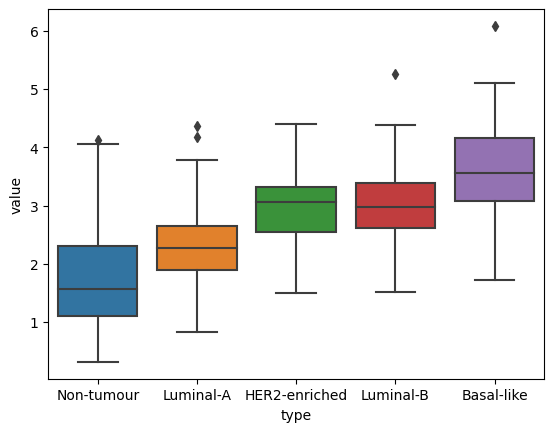

In [16]:
sns.boxplot(x=df["type"],y=df["value"],orient = "v")

In [17]:
# Version numéro 1
test = df.groupby("type")["value"].mean()
result = pd.DataFrame(index=test.index, columns=['LOGfc','fc'])
for group in test.index:
    other_groups = test.index.difference([group])
    average_value = test[other_groups].mean()
    fc = test[group].mean() - average_value
    result.at[group, 'LOGfc'] = fc
    result.at[group, 'fc'] = 2**fc
result

,LOGfc,fc
type,,
Basal-like,1.091924,2.131581
HER2-enriched,0.341225,1.266832
Luminal-A,-0.541802,0.686912
Luminal-B,0.332911,1.259553
Non-tumour,-1.224258,0.428018


In [18]:
# Version numéro 2
test = df.groupby("type")["value"].mean()
result = {'type': test.index, 'LOGfc': [None] * 5, 'fc': [None] * 5}
result = pd.DataFrame(result)
for group in result.index:
    other_groups = result.index.difference([group])
    average_value = test[other_groups].mean()
    fc = test[result.type[group]].mean() - average_value
    result.at[group, 'LOGfc'] = fc
    result.at[group, 'fc'] = 2**fc
result

,type,LOGfc,fc
0,Basal-like,1.091924,2.131581
1,HER2-enriched,0.341225,1.266832
2,Luminal-A,-0.541802,0.686912
3,Luminal-B,0.332911,1.259553
4,Non-tumour,-1.224258,0.428018


In [22]:
df = gene_expression('TCGA-BRCA',"EZH2",globals()['TCGA_BRCA'])
df2 = df.groupby("type")["value"].mean()
result = pd.DataFrame({'gene': ["EZH2"] * len(df2.index), 'dataset': ['TCGA-BRCA'] * len(df2.index), 'type': df2.index, 'LOGfc': [None] * len(df2.index),
                           'fc': [None] * len(df2.index), 'F': [None]*len(df2.index), 'pvalue': [None] * len(df2.index)})
for group in result.index:
    other_groups = result.index.difference([group])
    average_value = df2[other_groups].mean()
    fc = df2[group].mean() - average_value
    F, p_value = f_oneway(df['value'][df.type == result['type'][group]], df['value'][df.type != result['type'][group]])
    result.at[group, 'LOGfc'] = fc
    result.at[group, 'fc'] = 2**fc
    result.at[group, 'F'] = F
    result.at[group, 'pvalue'] = p_value
result

,gene,dataset,type,LOGfc,fc,F,pvalue
0,EZH2,TCGA-BRCA,Basal-like,1.091924,2.131581,408.423092,0.0
1,EZH2,TCGA-BRCA,HER2-enriched,0.341225,1.266832,21.176889,0.000005
2,EZH2,TCGA-BRCA,Luminal-A,-0.541802,0.686912,104.383327,0.0
3,EZH2,TCGA-BRCA,Luminal-B,0.332911,1.259553,58.209392,0.0
4,EZH2,TCGA-BRCA,Non-tumour,-1.224258,0.428018,252.853443,0.0


In [35]:
def get_logfc(dataset,gene,dataset2):
    df = gene_expression(dataset,gene,dataset2)
    df2 = df.groupby("type")["value"].mean()
    result = pd.DataFrame({'gene': [gene] * len(df2.index), 'dataset': [dataset] * len(df2.index), 'type': df2.index, 'LOGfc': [None] * len(df2.index),
                           'fc': [None] * len(df2.index), 'F': [None]*len(df2.index), 'pvalue': [None] * len(df2.index),
                           'FDR': [None] * len(df2.index)})
    for group in result.index:
        other_groups = result.index.difference([group])
        average_value = df2[other_groups].mean()
        fc = df2[group].mean() - average_value
        F, p_value = f_oneway(df['value'][df.type == result['type'][group]], df['value'][df.type != result['type'][group]])
        p_valeurs_corrigees = multipletests(p_value, method='fdr_bh')[1][0]
        result.at[group, 'LOGfc'] = fc
        result.at[group, 'fc'] = 2**fc
        result.at[group, 'F'] = F
        result.at[group, 'pvalue'] = p_value
        result.at[group, 'FDR'] = p_valeurs_corrigees
    return result
# get_logfc('Naderi-Caldas-2007',"BOP1",'Naderi_Caldas)
get_logfc('TCGA-BRCA',"EZH2",TCGA_BRCA)
get_logfc('TCGA-BRCA',"BOP1",TCGA_BRCA)

,gene,dataset,type,LOGfc,fc,F,pvalue,FDR
0,BOP1,TCGA-BRCA,Basal-like,1.184223,2.27241,330.693096,0.0,0.0
1,BOP1,TCGA-BRCA,HER2-enriched,-0.014224,0.990189,0.799812,0.371326,0.371326
2,BOP1,TCGA-BRCA,Luminal-A,-0.429357,0.742593,61.594212,0.0,0.0
3,BOP1,TCGA-BRCA,Luminal-B,0.082092,1.058552,7.381185,0.006684,0.006684
4,BOP1,TCGA-BRCA,Non-tumour,-0.822734,0.56537,82.705159,0.0,0.0


In [24]:
TCGA_BRCA.gene_symbol[1:len(TCGA_BRCA.gene_symbol)]

1                 A2M
2               A2MP1
3                NAT1
4                NAT2
5                NATP
             ...     
42846    LOC124909423
42847    LOC124909426
42848    LOC124909439
42849    LOC124909446
42850    LOC124909475
Name: gene_symbol, Length: 42850, dtype: string

In [30]:
def gene_expression(dataset,gene,dataset2):
    TDC = cancer[cancer["Dataset"] == dataset][["Luminal-A","Luminal-B","HER2-enriched","Basal-like"]]
    ech = cancer[cancer["Dataset"] == dataset]['Sample']
    type_cancer = TDC.apply(lambda row: ''.join(row.keys()[row == 1]), axis=1)
    type_cancer = pd.DataFrame(type_cancer)
    type_cancer = type_cancer.T
    type_cancer.columns = ech.to_list()
    
    dataset2.gene_symbol = dataset2.gene_symbol.convert_dtypes()
    EG = dataset2[dataset2.gene_symbol == gene][cancer[cancer["Dataset"] == dataset]['Sample']]
    df = pd.concat([type_cancer,EG],axis=0)
    if(df.shape[0] == 3):
      df.index = ['test','type', 'value']
    else:
        df.index = ['type', 'value']
    df = df.T
    df.value = pd.to_numeric(df.value)
    df['type'] = df['type'].replace({'': 'Non-tumour'})
    return df # sns.boxplot(x=df["type"],y=df["value"],orient = "v")
gene_expression('Naderi-Caldas-2007',"BOP1",globals()['Naderi_Caldas']) # -> renvoie aucun type
gene_expression('TCGA-BRCA',"EZH2",globals()['TCGA_BRCA']) # Lui il marche

,type,value
TCGA-A7-A0CE-11A,Non-tumour,1.371113
TCGA-A7-A0CH-11A,Non-tumour,0.940731
TCGA-A7-A0D9-11A,Non-tumour,0.592445
TCGA-A7-A0DB-11A,Non-tumour,1.155361
TCGA-A7-A0DC-11A,Non-tumour,1.053667
...,...,...
TCGA-WT-AB44-01A,Luminal-A,2.235114
TCGA-XX-A899-01A,Luminal-A,2.626276
TCGA-XX-A89A-01A,Luminal-A,2.641962
TCGA-Z7-A8R5-01A,Luminal-A,1.724607


In [39]:
df = get_logfc('TCGA-BRCA',TCGA_BRCA.gene_symbol[0],TCGA_BRCA)
for g in TCGA_BRCA.gene_symbol[1:len(TCGA_BRCA.gene_symbol)]:
    df = pd.concat([df,get_logfc('TCGA-BRCA',g,TCGA_BRCA)],axis=0)

,gene,dataset,type,LOGfc,fc,F,pvalue,FDR
0,A1BG,TCGA-BRCA,Basal-like,-0.022586,0.984466,35.299432,0.0,0.0
1,A1BG,TCGA-BRCA,HER2-enriched,-0.025979,0.982154,16.428854,0.000054,0.000054
2,A1BG,TCGA-BRCA,Luminal-A,0.030754,1.021546,50.570851,0.0,0.0
3,A1BG,TCGA-BRCA,Luminal-B,0.011032,1.007676,0.004666,0.945552,0.945552
4,A1BG,TCGA-BRCA,Non-tumour,0.006779,1.00471,0.686409,0.407551,0.407551
...,...,...,...,...,...,...,...,...
0,ADH4,TCGA-BRCA,Basal-like,-0.033752,0.976876,1.215331,0.270496,0.270496
1,ADH4,TCGA-BRCA,HER2-enriched,-0.136031,0.910019,10.900043,0.000989,0.000989
2,ADH4,TCGA-BRCA,Luminal-A,-0.072414,0.951046,32.084071,0.0,0.0
3,ADH4,TCGA-BRCA,Luminal-B,-0.13577,0.910184,30.365553,0.0,0.0


In [ ]:
# Il faut reset les indices
df = df.reset_index(drop=True)

1455          AR
1535        RHOB
1680        ART3
2990        CA12
3495       CCNE1
7685         EN1
7975        ESR1
8375        FBP1
8689       VEGFD
8755       FOXC1
9560       GATA3
9905        GJB3
11800      FOXA1
13245    IL12RB2
14340      KRT16
Name: gene, dtype: object

In [ ]:
# Le dataframe est stocké 
df.to_pickle('TCGA_volcano.pkl')

NameError: name 'df' is not defined

In [28]:
# Il suffit de mettre la commande suivante pour le recharger : 
df = pd.read_pickle('TCGA_volcano.pkl')
df

,gene,dataset,type,LOGfc,fc,F,pvalue,FDR
0,A1BG,TCGA-BRCA,Basal-like,-0.022586,0.984466,35.299432,0.0,0.0
1,A1BG,TCGA-BRCA,HER2-enriched,-0.025979,0.982154,16.428854,0.000054,0.000054
2,A1BG,TCGA-BRCA,Luminal-A,0.030754,1.021546,50.570851,0.0,0.0
3,A1BG,TCGA-BRCA,Luminal-B,0.011032,1.007676,0.004666,0.945552,0.945552
4,A1BG,TCGA-BRCA,Non-tumour,0.006779,1.00471,0.686409,0.407551,0.407551
...,...,...,...,...,...,...,...,...
15740,SCGB2A2,TCGA-BRCA,Basal-like,-4.446059,0.045878,259.574512,0.0,0.0
15741,SCGB2A2,TCGA-BRCA,HER2-enriched,1.283064,2.433553,2.556784,0.110081,0.110081
15742,SCGB2A2,TCGA-BRCA,Luminal-A,1.827783,3.549912,81.947146,0.0,0.0
15743,SCGB2A2,TCGA-BRCA,Luminal-B,-0.299983,0.812262,5.194008,0.022837,0.022837


In [2]:
df

NameError: name 'df' is not defined

### VOLCANO PLOT

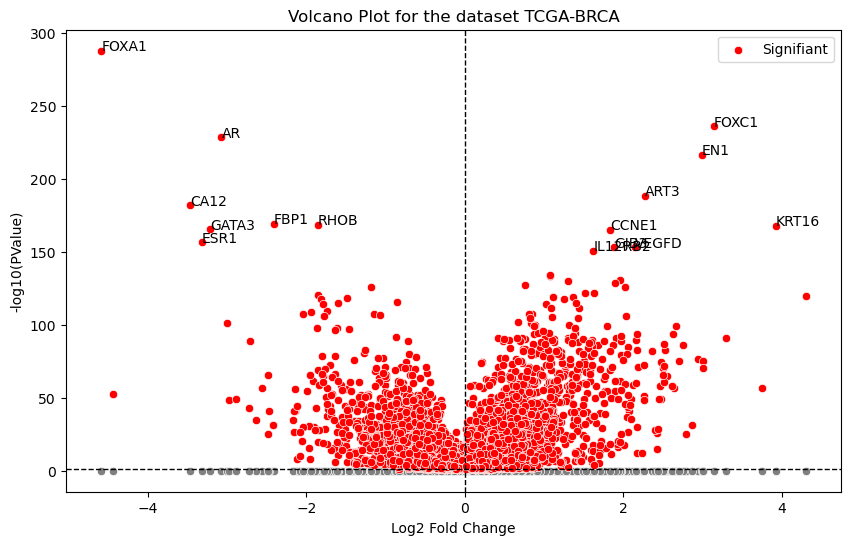

In [ ]:
# Définir un seuil de significativité pour le PValue
seuil = -np.log10(0.05)
pvlog10 = -np.log10(df.pvalue.astype(float))
pvlog10 = pvlog10.reset_index(drop=True)
# df["gene"][pvlog10[pvlog10 > 150].index]

# Créer le volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LOGfc', y='pvalue', data=df, color='grey')
sns.scatterplot(x=df[-np.log10(df.pvalue.astype(float)) > seuil]['LOGfc'].values,
                y=pvlog10[pvlog10 > seuil].values,
                color='red', label='Signifiant')

# plt.ylim(-50,100)

plt.title('Volcano Plot for the dataset TCGA-BRCA') # plt.title('Volcano Plot pour le jeu de données TCGA-BRCA')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(PValue)')

# Ajouter une ligne verticale pour mettre en évidence le seuil de significativité
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.axhline(y=seuil, color='black', linestyle='--', linewidth=1)

# Donner le label des -log10(pv) superieurs à 150 
for i,gene in zip(df["gene"][pvlog10[pvlog10 > 150].index].index,df["gene"][pvlog10[pvlog10 > 150].index].values):
    plt.annotate(gene, (df.iloc[i]['LOGfc'], -np.log10(df.iloc[i]['pvalue'].astype(float))))

plt.legend()
plt.show()

In [ ]:
df.groupby("type")["value"].mean()[0:4].mean()

2.9635992671062485

In [ ]:
# Calcul des moyennes par type de cancer
df.groupby("type")["value"].mean()

# Différence de moyennes entre Tumeurs et non tumeurs
df.groupby("type")["value"].mean()[0:4].mean() - df.groupby("type")["value"].mean()[4:5]

# Fold change 
2**(df.groupby("type")["value"].mean()[0:4].mean() - df.groupby("type")["value"].mean()[4:5])

type
Non-tumour    2.336353
Name: value, dtype: float64

Création d'un code reproductible 

In [26]:
def gene_expression(dataset,gene,dataset2):
    TDC = cancer[cancer["Dataset"] == dataset][["Luminal-A","Luminal-B","HER2-enriched","Basal-like"]]
    ech = cancer[cancer["Dataset"] == dataset]['Sample']
    type_cancer = TDC.apply(lambda row: ''.join(row.keys()[row == 1]), axis=1)
    type_cancer = pd.DataFrame(type_cancer)
    type_cancer = type_cancer.T
    type_cancer.columns = ech.to_list()
    
    dataset2.gene_symbol = dataset2.gene_symbol.convert_dtypes()
    EG = dataset2[dataset2.gene_symbol == gene][cancer[cancer["Dataset"] == dataset]['Sample']]
    df = pd.concat([type_cancer,EG],axis=0)
    if(df.shape[0] == 3):
      df.index = ['test','type', 'value']
    else:
        df.index = ['type', 'value']
    df = df.T
    df.value = pd.to_numeric(df.value)
    df['type'] = df['type'].replace({'': 'Non-tumour'})
    return df # sns.boxplot(x=df["type"],y=df["value"],orient = "v")
gene_expression('Naderi-Caldas-2007',"BOP1",globals()['Naderi_Caldas']) # -> renvoie aucun type
gene_expression('TCGA-BRCA',"EZH2",globals()['TCGA_BRCA']) # Lui il marche

,type,value
TCGA-A7-A0CE-11A,Non-tumour,1.371113
TCGA-A7-A0CH-11A,Non-tumour,0.940731
TCGA-A7-A0D9-11A,Non-tumour,0.592445
TCGA-A7-A0DB-11A,Non-tumour,1.155361
TCGA-A7-A0DC-11A,Non-tumour,1.053667
...,...,...
TCGA-WT-AB44-01A,Luminal-A,2.235114
TCGA-XX-A899-01A,Luminal-A,2.626276
TCGA-XX-A89A-01A,Luminal-A,2.641962
TCGA-Z7-A8R5-01A,Luminal-A,1.724607


In [ ]:
gene_expression('Naderi-Caldas-2007',"BOP1",globals()['Naderi_Caldas']).index

Index(['Naderi-Caldas-2007-2075', 'Naderi-Caldas-2007-2078',
       'Naderi-Caldas-2007-2079', 'Naderi-Caldas-2007-2081',
       'Naderi-Caldas-2007-2083', 'Naderi-Caldas-2007-2086',
       'Naderi-Caldas-2007-2087', 'Naderi-Caldas-2007-2091',
       'Naderi-Caldas-2007-2094', 'Naderi-Caldas-2007-2097',
       ...
       'Naderi-Caldas-2007-2474', 'Naderi-Caldas-2007-2479',
       'Naderi-Caldas-2007-2483', 'Naderi-Caldas-2007-2484',
       'Naderi-Caldas-2007-2492', 'Naderi-Caldas-2007-2496',
       'Naderi-Caldas-2007-2498', 'Naderi-Caldas-2007-2499',
       'Naderi-Caldas-2007-2504', 'Naderi-Caldas-2007-2505'],
      dtype='object', length=113)

In [ ]:
cancer[[cancer["Sample"] == gene_expression('Naderi-Caldas-2007',"BOP1",globals()['Naderi_Caldas']).index]]

ValueError: ('Lengths must match to compare', (3700,), (113,))

In [ ]:
# Les noms de datasets présent dans les données et ceux que nous avoir défini dans les variables globales 
# car nous avons des "dash" (-) pour definir les dataset dans nos données. 
# Cependant, dans les variables globales, nous ne pouvons pas définir de dash ("-")
datasets = ['TCGA_BRCA', 'E_MTAB_365', 'GSE21653', 'GSE25066', 'GSE42568',
       'Yau', 'Naderi_Caldas', 'Miller']
datasets2 = cancer["Dataset"].unique()

In [ ]:
TCGA_BRCA["gene_symbol"] = TCGA_BRCA["gene_symbol"].apply(lambda x: str(x) if pd.notna(x) else x)

In [ ]:
%%time
for d in datasets:
    df = globals()[d]
    gen = df.gene_symbol.unique()
    for g in gen:
        gene_expression(d,g,df).head()

KeyboardInterrupt: 

In [ ]:
df = df[df.type != "Non-tumour"]

NameError: name 'df' is not defined

In [ ]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(type)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
# get F et pvalue
F, pvalue = round(anova_table.F[0],3) , round(anova_table["PR(>F)"][0],3)

In [ ]:
df

,type,value
TCGA-A7-A0CE-11A,Non-tumour,1.371113
TCGA-A7-A0CH-11A,Non-tumour,0.940731
TCGA-A7-A0D9-11A,Non-tumour,0.592445
TCGA-A7-A0DB-11A,Non-tumour,1.155361
TCGA-A7-A0DC-11A,Non-tumour,1.053667
...,...,...
TCGA-WT-AB44-01A,Luminal-A,2.235114
TCGA-XX-A899-01A,Luminal-A,2.626276
TCGA-XX-A89A-01A,Luminal-A,2.641962
TCGA-Z7-A8R5-01A,Luminal-A,1.724607


In [ ]:
%%time
# Création de la fonction pour créer les ANOVA
def get_anova(df):
    df = df[df.type != "Non-tumour"]
    # Ordinary Least Squares (OLS) model
    model = ols('value ~ C(type)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    F, pvalue = round(anova_table.F[0],3) , round(anova_table["PR(>F)"][0],3)
    return F,pvalue

get_anova(df)

Wall time: 35.6 ms


(242.247, 0.0)

In [ ]:
%%time
# Création de la fonction pour créer les ANOVA
def get_anova(df):
    df = df[df.type != "Non-tumour"]
    # Ordinary Least Squares (OLS) model
    model = ols('value ~ C(type)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    F, pvalue = round(anova_table.F[0],3) , round(anova_table["PR(>F)"][0],3)
    return F,pvalue



for ds,d in zip(datasets,datasets2):
    df = globals()[ds]
    gen = df.gene_symbol.unique()
    for g in gen:
        df = gene_expression(d,g,df)
        print(g)
        print(d)
        print(get_anova(df))
        

#    yield F, pvalue

# Utiliser la fonction dans une boucle ou pour un DataFrame particulier
# for result in filter_and_anova(df):
  #  print(result)

KeyError: 'TCGA-BRCA'

In [ ]:
for ds,d in zip(datasets,datasets2):
    print(ds)
    print(d)

TCGA-BRCA
TCGA_BRCA
E-MTAB-365
E_MTAB_365
GSE21653
GSE21653
GSE25066
GSE25066
GSE42568
GSE42568
Yau-2010
Yau
Naderi-Caldas-2007
Naderi_Caldas
Miller-2005
Miller


In [ ]:
test = globals()['TCGA_BRCA']
test = test.gene_symbol.unique()
# for t,d in zip(test,datasets2):
#    print(t)
  
    for t in test:
        print(t)

A1BG
A2M
A2MP1
NAT1
NAT2
NATP
SERPINA3
AADAC
AAMP
AANAT
AARS1
ABAT
ABCA1
ABCA2
ABCA3
ABCB7
ABCF1
ABCA4
ABL1
AOC1
ABL2
ABO
ABR
ACAA1
ACACA
ACACB
ACADL
ACADM
ACADS
ACADSB
ACADVL
ACAT1
ACAT2
ASIC2
ASIC1
ACHE
ACLY
ACO1
ACR
ACO2
ACOX1
ACP1
ACP2
ACP5
ACP3
ACRV1
ACTA1
ACTA2
ACTB
ACTBP2
ACTBP4
ACTBP6
ACTBP7
ACTBP8
ACTBP9
ACTC1
ACTG1
ACTG2
ACTG1P1
ACTG1P2
ACTG1P3
ACTN4
ACTG1P9
ACTG1P10
ACTL6A
ACTN1
ACTN2
ACTN3
ACVR1
ACVR1B
ACVR2A
ACVR2B
ACVRL1
ACY1
ACYP1
ACYP2
ADA
ADAM8
ADAM10
ADAR
ADARB1
ADARB2
ADCY1
ADCY2
ADCY3
ADCY5
ADCY6
ADCY7
ADCY8
ADCY9
ADCYAP1
ADCYAP1R1
ADD1
ADD2
ADD3
PLIN2
ADH1A
ADH1B
ADH1C
ADH4
ADH5
ADH6
ADH7
ADK
ADM
ADORA1
ADORA2A
ADORA2B
ADORA2BP1
ADORA3
ADPRH
PARP1
PARP4
PARP1P1
PARP1P2
ADRA1D
ADRA1B
ADRA1A
ADRA2A
ADRA2B
ADRA2C
ADRB1
ADRB2
ADRB3
GRK2
GRK3
ADSL
ADSS2
AP2A1
AP2A2
AP1B1
AP2B1
AP1G1
AEBP1
TLE5
CRISP1
AFG3L1P
AFM
AFP
AGA
ACAN
AGER
AGL
AGRP
JAG1
AGT
AGTR1
AGTR2
APLNR
AGXT
NR0B1
AHCY
AHR
AHSG
AIF1
CRYBG1
AK1
AK2
AK4
AK4P1
AKT1
AKT2
ALAD
ALAS1
ALAS2
ALB
ALCAM
ABCD1
ALDH1A1


In [ ]:
datasets2

['TCGA_BRCA',
 'E_MTAB_365',
 'GSE21653',
 'GSE25066',
 'GSE42568',
 'Yau',
 'Naderi_Caldas',
 'Miller']

In [ ]:
globals().get(datasets[4])

,id_gene,gene_symbol,GSM1045191,GSM1045192,GSM1045193,GSM1045194,GSM1045195,GSM1045196,GSM1045197,GSM1045198,...,GSM1045302,GSM1045303,GSM1045304,GSM1045305,GSM1045306,GSM1045307,GSM1045308,GSM1045309,GSM1045310,GSM1045311
0,1,A1BG,5.5459336169041,5.45954999004718,5.53164787056418,5.24262775201498,5.18936877025995,5.20697596963813,6.25729176859442,5.90663544324135,...,5.67108914328277,5.23567843614021,7.22379160930498,7.73673126779167,5.32494730100133,6.09084949838814,5.60399106040569,5.41746262090493,5.89391334480664,6.27346849620387
1,2,A2M,4.22854233516045,4.69291262038986,5.02371726458848,4.43696146115782,4.30930608933028,4.14167272619265,4.59650594825906,4.84431718317814,...,5.07835919933533,4.41509196758211,4.13016467531115,4.84664672475861,4.28955466137965,4.14795596469455,4.28844773657534,3.95272920153999,4.50479563957163,3.89864735021175
2,3,A2MP1,4.17892431534899,5.44190337110931,6.47719978645636,6.15790277265651,4.1709010734664,4.12268319254433,4.06789898493427,4.85553516337229,...,5.28138710086777,5.21249025317057,4.31403758183134,4.86016602276673,4.74425077407954,4.54471418487181,4.30380911734106,4.69590335985141,4.90402789880749,4.02868494115524
3,9,NAT1,8.07195597699704,4.55513464537055,6.41426340809915,7.8187119613419,5.86166205061897,6.45201596260545,6.73445119411224,8.54363074560192,...,4.94614965538933,7.59938269818236,8.75769209935955,11.2279762897403,9.08341226713487,11.3229090953355,11.924129044579,11.6182849841223,11.799150961428,10.3043292486738
4,10,NAT2,4.60021012875162,3.96605976982609,4.92008072542543,4.73772134391316,3.7596578846027,4.10943766786033,4.28398309062308,4.69998890504307,...,4.6399138358643,4.0954662090646,4.27473426642759,4.9625578188208,4.77457972311538,5.99192858052561,7.63480409084887,4.05889053623564,4.23860765585708,4.31747943167781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23030,106614088,MIR34AHG,5.93856584004535,5.90144542317166,6.15833399715144,5.62048163997919,5.09876313929951,5.29108529068273,4.47435809938805,5.10830327817342,...,6.60091487882842,6.2791873780822,6.20958713872603,6.14643150165417,5.93495766696269,5.87522749911957,7.04250038700249,7.1693227236167,6.2761387008429,6.72220252959171
23031,106660612,LINC00680,5.85476164297998,5.72739332455309,5.09836940772795,5.34421390380743,6.29322734162731,6.64473337003511,5.75720683122458,6.28278896622346,...,5.76641599095699,6.42320496582585,5.54713975138399,5.52957240352906,5.86952062454859,5.87545137944181,5.83404485061656,6.52502122509572,6.09755582318063,5.96586436994731
23032,106699570,DYNC1LI2-DT,2.95644929663375,3.16128841879366,3.30405070702027,2.80473269674118,2.83534791836721,2.84229645216825,3.15343916974255,2.96770410378948,...,3.32791386494446,2.91809610288008,2.83726039638038,3.10575981324105,2.81012488335013,2.76907062996491,3.1017945422851,3.06755936610526,2.97885397529275,2.97400269750418
23033,106707243,PRH1-TAS2R14,5.02910325828123,5.25188554327555,4.31644858310728,3.51084870450645,4.83338724448878,4.79355283740849,4.79727555398701,4.87719538480733,...,4.02349876059726,4.63603602207972,5.36354423569936,4.93425355229933,4.15508619227941,4.8721670661034,4.35761861170037,5.01662393304563,4.29176577416383,4.93887365140686


#### Analyse de données single cell

#### Réaliser une analyse de survie sur python 

On commence avec un premier exemple dans le jeu de données EMTAB pour le gène EZH2

In [ ]:
expression = E_MTAB_365[E_MTAB_365.gene_symbol == "EZH2"]
expression.dropna(axis=1)

,id_gene,gene_symbol,CIT_DSOA_001,CIT_DSOA_002,CIT_DSOA_003,CIT_DSOA_004,CIT_DSOA_005,CIT_DSOA_006,CIT_DSOA_007,CIT_DSOA_008,...,CIT_DSOA_528,CIT_DSOA_529,CIT_DSOA_530,CIT_DSOA_531,CIT_DSOA_532,CIT_DSOA_533,CIT_DSOA_534,CIT_DSOA_535,CIT_DSOA_536,CIT_DSOA_537
1513,2146,EZH2,8.426623,6.877132,7.572731,5.29231,6.226845,6.886607,7.484511,6.418675,...,6.682147,6.449759,5.907661,6.008499,6.067995,6.238021,6.1007,6.347094,5.382535,5.934367


In [ ]:
# Recuperons maintenant les données de survie 
survie = E_MTAB_365_EG[["id_sample","os_months","os_censor","dfs_months","dfs_censor"]]
survie = survie.dropna()

In [ ]:
expression = expression[E_MTAB_365_EG[["id_sample","os_months","os_censor","dfs_months","dfs_censor"]]['id_sample'].values].dropna(axis=1)

In [ ]:
expression = expression[survie.id_sample].T
expression.columns = ["value"]

In [ ]:
survie = pd.concat([survie.reset_index(drop=True),expression.reset_index(drop=True)],axis=1)

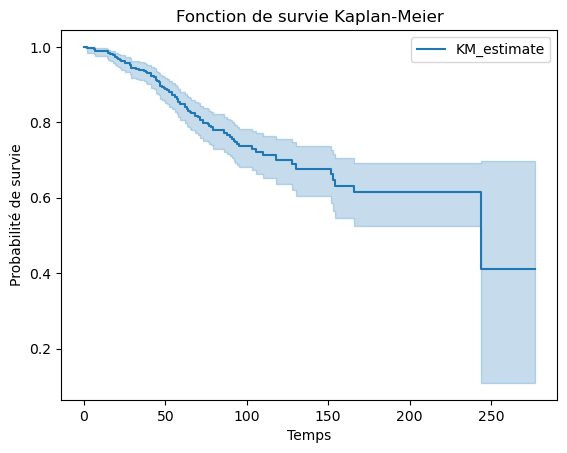

In [ ]:
# Initialiser le modèle Kaplan-Meier
kmf = KaplanMeierFitter()

# Ajuster le modèle aux données de survie
kmf.fit(durations=survie['os_months'], event_observed=survie['os_censor'])

# Afficher la fonction de survie
kmf.plot_survival_function()
plt.title('Fonction de survie Kaplan-Meier')
plt.xlabel('Temps')
plt.ylabel('Probabilité de survie')
plt.show()

In [ ]:
mediane = np.percentile(survie["value"],50)
survie[survie["value"] > mediane]["os_months"]

0       78.0
1       62.0
2      110.0
5      104.0
6       75.0
       ...  
406     28.0
411     97.0
413    166.0
417    186.0
418    104.0
Name: os_months, Length: 214, dtype: float64

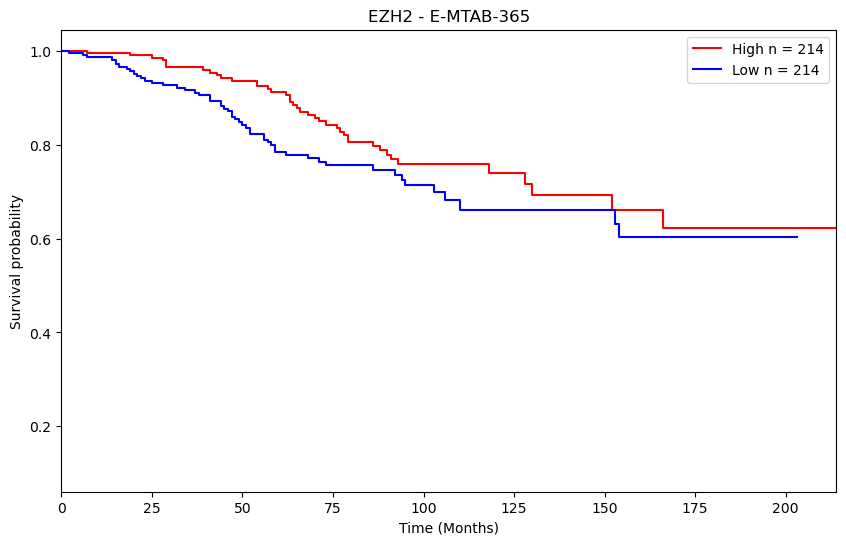

In [ ]:
# Définir le critère pour séparer les 2 groupes : 
mediane = np.percentile(survie["value"],50)

# Créer deux instances distinctes de KaplanMeierFitter
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

# Definition des 2 groupes (Low et High)
high = survie[survie["value"] > mediane]
low = survie[survie["value"] < mediane]

# Ajuster les modèles aux données de survie respectives
kmf1.fit(durations=high["os_months"], event_observed=high['os_censor'])
kmf2.fit(durations=low["os_months"], event_observed=low['os_censor'])

# Tracer les courbes de survie
plt.figure(figsize=(10, 6))
kmf2.plot_survival_function(label=f'High n = {high.shape[0]}',color='red',ci_alpha=0)
kmf1.plot_survival_function(label=f'Low n = {low.shape[0]}',color='blue',ci_alpha=0)


plt.xlim(0,min(len(low),len(high)))

# Ajouter des titres et légendes
plt.title(f'EZH2 - E-MTAB-365') 
# plt.title(f'EZH2 - E-MTAB-365\ncox p-value : {res['p'].values}\nlogrank p-value : {res_logr.summary['p']}')
plt.xlabel('Time (Months)') # plt.xlabel('Temps')
plt.ylabel('Survival probability') # plt.ylabel('Probabilité de survie')
plt.legend()

# Afficher le graphique
plt.show()


Test de Cox

In [ ]:
low['group'] = ["Low"]*low.shape[0]
high['group'] = ["High"]*high.shape[0]
data = pd.concat([low,high])
coxph = CoxPHFitter()
coxph.fit(data, duration_col='os_months', event_col='os_censor', formula='group')

C:\Users\zergu\AppData\Local\Temp\ipykernel_6252\4200744920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low['group'] = ["Low"]*low.shape[0]
C:\Users\zergu\AppData\Local\Temp\ipykernel_6252\4200744920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high['group'] = ["High"]*high.shape[0]


<lifelines.CoxPHFitter: fitted with 428 total observations, 334 right-censored observations>

In [ ]:
res = coxph.summary
# Obtenir la p-value
res['p'].values

array([0.10583107])

Test du LogRank

In [ ]:
kmf_A = KaplanMeierFitter()
kmf_B = KaplanMeierFitter()
kmf_A.fit(durations=low['os_months'], event_observed=low['os_censor'], label='Low')
kmf_B.fit(durations=high['os_months'], event_observed=high['os_censor'], label='High')
res_logr = logrank_test(low['os_months'], high['os_months'], event_observed_A=low['os_censor'], event_observed_B=high['os_censor'])
print(res_logr.summary)

   test_statistic         p  -log2(p)
0        2.643677  0.103963  3.265862
